### ETH EDA

In [1]:
import pandas as pd

file_path = "/Users/halladaykinsey/Desktop/ETH_1min.csv"
df = pd.read_csv(file_path)

# Displaying basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984012 entries, 0 to 1984011
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unix Timestamp  int64  
 1   Date            object 
 2   Symbol          object 
 3   Open            float64
 4   High            float64
 5   Low             float64
 6   Close           float64
 7   Volume          float64
dtypes: float64(5), int64(1), object(2)
memory usage: 121.1+ MB
None
   Unix Timestamp                 Date  Symbol    Open    High     Low  \
0   1586995200000  2020-04-16 00:00:00  ETHUSD  152.94  152.94  151.33   
1   1586995140000  2020-04-15 23:59:00  ETHUSD  152.94  152.94  152.94   
2   1586995080000  2020-04-15 23:58:00  ETHUSD  153.17  153.17  152.94   
3   1586995020000  2020-04-15 23:57:00  ETHUSD  152.96  153.20  152.96   
4   1586994960000  2020-04-15 23:56:00  ETHUSD  153.14  153.14  152.96   

    Close      Volume  
0  151.33  112.724931  
1  152.94    0.000000  
2  152.94   

In [2]:
import numpy as np

# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values (if any)
df.dropna(inplace=True)

Unix Timestamp    0
Date              0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume            0
dtype: int64


In [3]:
# Summary statistics
print(df.describe())

       Unix Timestamp          Open          High           Low         Close  \
count    1.984012e+06  1.984012e+06  1.984012e+06  1.984012e+06  1.984012e+06   
mean     6.154583e+11  2.418247e+02  2.419602e+02  2.416817e+02  2.418249e+02   
std      7.621617e+11  2.415172e+02  2.417080e+02  2.413119e+02  2.415171e+02   
min      1.462801e+09  0.000000e+00  5.990000e+00  0.000000e+00  5.990000e+00   
25%      1.492561e+09  5.007000e+01  5.008750e+01  5.006000e+01  5.007000e+01   
50%      1.522321e+09  1.833200e+02  1.833700e+02  1.832600e+02  1.833200e+02   
75%      1.554502e+12  3.010100e+02  3.011400e+02  3.009300e+02  3.010100e+02   
max      1.586995e+12  1.420000e+03  1.420010e+03  1.419890e+03  1.420000e+03   

             Volume  
count  1.984012e+06  
mean   2.612284e+01  
std    4.444555e+02  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    7.132165e+00  
max    2.764235e+05  


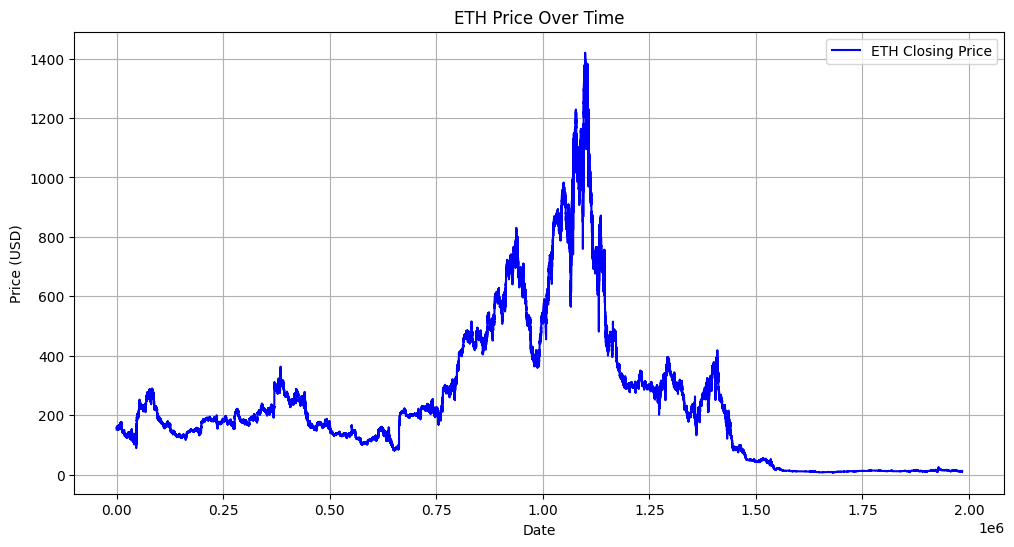

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['Close'], color="blue", label="ETH Closing Price")
plt.title("ETH Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

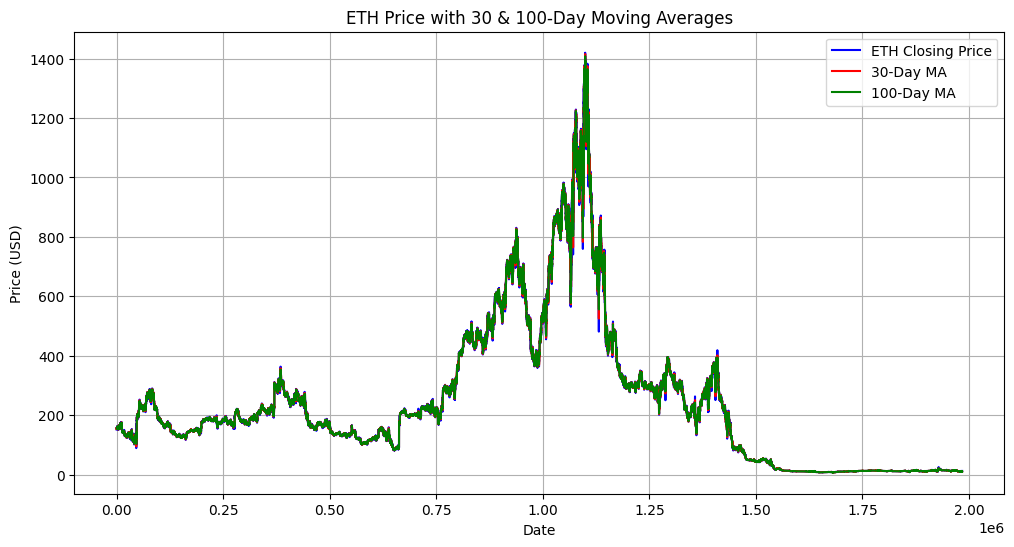

In [5]:
# Calculate 30-day & 100-day moving averages
df["MA_30"] = df["Close"].rolling(window=30).mean()
df["MA_100"] = df["Close"].rolling(window=100).mean()

# Plot moving averages
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df["Close"], label="ETH Closing Price", color="blue")
sns.lineplot(x=df.index, y=df["MA_30"], label="30-Day MA", color="red")
sns.lineplot(x=df.index, y=df["MA_100"], label="100-Day MA", color="green")

plt.title("ETH Price with 30 & 100-Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

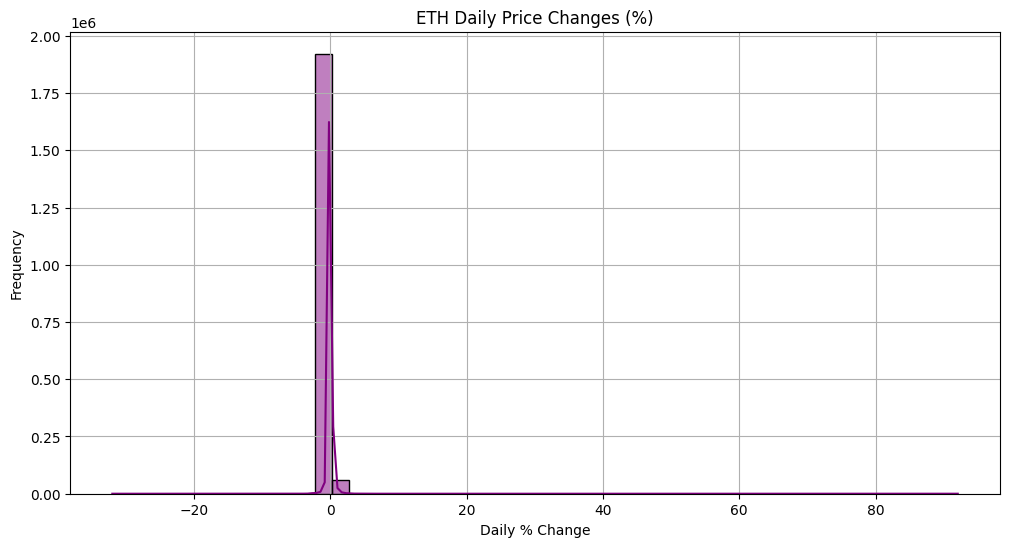

In [6]:
df["Daily_Change"] = df["Close"].pct_change() * 100

plt.figure(figsize=(12, 6))
sns.histplot(df["Daily_Change"].dropna(), bins=50, kde=True, color="purple")
plt.title("ETH Daily Price Changes (%)")
plt.xlabel("Daily % Change")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Model Attempt 1: CNN That Worked for BTC 

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# TRAINING ON SUBSET - CHANGE 
df = df.iloc[-10000:] 

# Excluding volume
df = df[['Open', 'High', 'Low', 'Close']]

# Adding moving averages
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['MA_100'] = df['Close'].rolling(window=100).mean()

df.dropna(inplace=True)

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

print(df.head())

             Open      High       Low     Close     MA_30   MA_100
1974111  0.855833  0.344697  0.855833  0.344697  0.408072  0.42446
1974112  0.855833  0.344697  0.855833  0.344697  0.408072  0.42446
1974113  0.855833  0.344697  0.855833  0.344697  0.408072  0.42446
1974114  0.855833  0.344697  0.855833  0.344697  0.408072  0.42446
1974115  0.855833  0.344697  0.855833  0.344697  0.408072  0.42446


In [4]:
def create_sequences(data, target_column, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps].values)
        y.append(data.iloc[i+time_steps][target_column])
    return np.array(X), np.array(y)

# Creating sequences
time_steps = 30  # Using past 30 minutes to predict the next close price
X, y = create_sequences(df, target_column="Close", time_steps=time_steps)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (7896, 30, 6)
Testing data shape: (1975, 30, 6)


In [5]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten
from keras.optimizers import Adam

model = Sequential()

# 1st Conv1D Layer
model.add(Conv1D(filters=8, kernel_size=3, strides=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# 2nd Conv1D Layer
model.add(Conv1D(filters=16, kernel_size=3, strides=1, activation='relu'))
model.add(Dropout(0.3))

# Flatten dense output
model.add(Flatten())

# Connected layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

# Compiling
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()

/Users/halladaykinsey/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 8)          │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        13,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,929 (54.41 KB)

 Trainable params: 13,929 (54.41 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from keras.callbacks import ModelCheckpoint, CSVLogger
import os

# Save model checkpoints
checkpoint = ModelCheckpoint("/Users/halladaykinsey/capstone-project/capstone-models/models/cnn_eth_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Log training history
csv_logger = CSVLogger("/Users/halladaykinsey/capstone-project/capstone-models/logs/eth_cnn_training_log.csv")

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, csv_logger],
    verbose=1
)

Epoch 1/50
450/494 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0376
Epoch 1: val_loss improved from inf to 0.01442, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/cnn_eth_model.h5


494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0357 - val_loss: 0.0144
Epoch 2/50
488/494 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0059
Epoch 2: val_loss improved from 0.01442 to 0.01422, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/cnn_eth_model.h5


494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0059 - val_loss: 0.0142
Epoch 3/50
455/494 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0039
Epoch 3: val_loss did not improve from 0.01422
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - val_loss: 0.0156
Epoch 4/50
490/494 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0035
Epoch 4: val_loss did not improve from 0.01422
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0035 - val_loss: 0.0155
Epoch 5/50
460/494 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0029
Epoch 5: val_loss did not improve from 0.01422
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0029 - val_loss: 0.0147
Epoch 6/50
441/494 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0027
Epoch 6: val_loss did not improve from 0.01422
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027 - val_loss: 0.0147
Epoch 7/50
490/494 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0025
Epoch 7: val_loss did not improve from 0.01422
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0028 - val_loss: 0.0137
Epoch 9/50
453/494 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022  
Epoch 9: val_loss improved from 0.01368 to 0.01031, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/cnn_eth_model.h5


494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 10/50
464/494 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.0030
Epoch 10: val_loss did not improve from 0.01031
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0030 - val_loss: 0.0143
Epoch 11/50
482/494 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.0026
Epoch 11: val_loss did not improve from 0.01031
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 12/50
492/494 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 0.0023
Epoch 12: val_loss did not improve from 0.01031
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0119
Epoch 13/50
492/494 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.0021
Epoch 13: val_loss did not improve from 0.01031
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0021 - val_loss: 0.0134
Epoch 14/50
479/494 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.0024
Epoch 14: val_loss did not improve from 0.01031
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms

494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019 - val_loss: 0.0100
Epoch 26/50
448/494 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0021
Epoch 26: val_loss did not improve from 0.01004
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0021 - val_loss: 0.0145
Epoch 27/50
450/494 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 0.0019
Epoch 27: val_loss did not improve from 0.01004
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019 - val_loss: 0.0124
Epoch 28/50
441/494 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0020
Epoch 28: val_loss did not improve from 0.01004
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020 - val_loss: 0.0137
Epoch 29/50
442/494 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0021
Epoch 29: val_loss did not improve from 0.01004
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0021 - val_loss: 0.0145
Epoch 30/50
447/494 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.0020
Epoch 30: val_loss did not improve from 0.01004
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


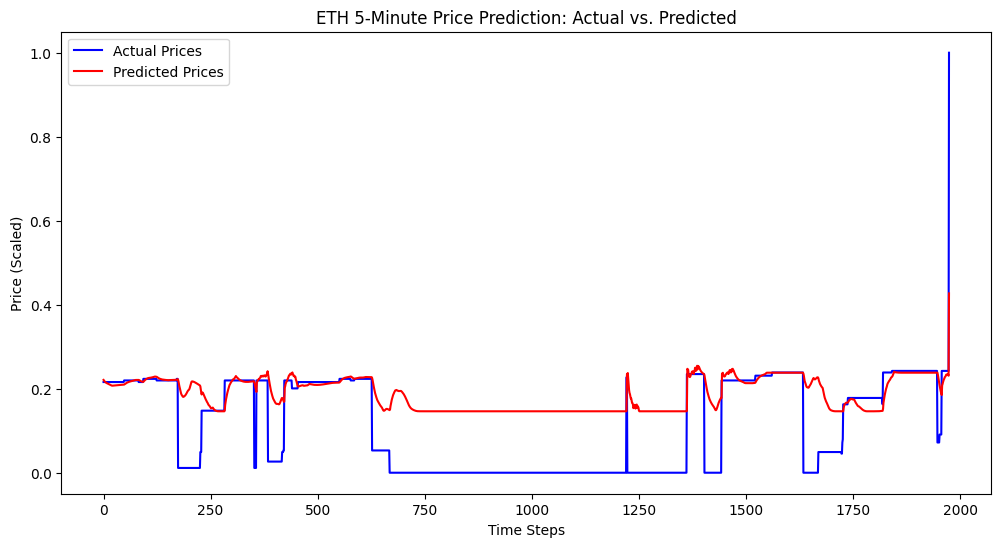

In [10]:
import matplotlib.pyplot as plt

# Making predictions
y_pred = model.predict(X_test)

# Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", color="red")
plt.title("ETH 5-Minute Price Prediction: Actual vs. Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Price (Scaled)")
plt.legend()
plt.show()